In [1]:
import pandas as pd
from binance.client import Client
import ta
import matplotlib.pyplot as plt
import pandas as pd
import ta
import time
import json
from math import *
import datetime
import numpy as np
import yfinance as yf
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.dates import DateFormatter, date2num, WeekdayLocator, DayLocator, MONDAY
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score 
import quandl
import seaborn as sns
from matplotlib.pyplot import figure
import plotly.graph_objs as go
%matplotlib inline



# Récupération des data qui nous intéressent

In [2]:
def get_data(ticker):
    data = yf.Ticker(ticker+"-USD").history(period="max").reset_index()[['Date','Open']]
    return data
btcdata = get_data("BTC")
ethdata =  get_data("ETH")
soldata =  get_data("SOL")
adadata =  get_data("ADA")
bnbdata =  get_data("BNB")
golddata= yf.download("GOLD", start="2014-09-17", end="2022-01-31")

[*********************100%***********************]  1 of 1 completed


In [3]:
#Les colonnes sont dans le bon format et il n'y a pas de NaN
btcdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2796 entries, 0 to 2795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2796 non-null   datetime64[ns]
 1   Open    2796 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 43.8 KB


# Analyse des corrélation entre plusieurs Blockchains

In [4]:
df1 = pd.merge(btcdata,ethdata,on='Date',how="inner")
df2 = pd.merge(df1, soldata, on='Date', how='inner')
df3 = pd.merge(df2, adadata, on='Date', how='inner')
df4 = pd.merge(df3, bnbdata, on='Date', how='inner')
df4.set_index('Date',inplace = True)
df4.columns = [['BTC','ETH','SOL','ADA','BNB']]


/var/folders/hg/q1z14_qd15l6_6h3q13r21280000gn/T/ipykernel_39639/797391367.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Open_x'} in the result is deprecated and will raise a MergeError in a future version.
  df3 = pd.merge(df2, adadata, on='Date', how='inner')


In [5]:
#Toutes fortement corrélé avec le BTC => Solana (SOL) un peu moins
df4.corr().round(2)*100

BTC    ETH    SOL    ADA    BNB
BTC  100.0   88.0   67.0   83.0   88.0
ETH   88.0  100.0   88.0   88.0   96.0
SOL   67.0   88.0  100.0   72.0   81.0
ADA   83.0   88.0   72.0  100.0   86.0
BNB   88.0   96.0   81.0   86.0  100.0

In [6]:
data_btc_trend = pd.read_csv('multiTimeline_BTC.csv', skiprows=3, skipfooter= 1, names= ['Mois', 'BTC'])

/Users/alexandremasson05/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [7]:
data_btc_trend['Mois'] = pd.to_datetime(data_btc_trend['Mois'])


In [8]:
data_btc_trend = data_btc_trend.replace('<\xa01', '0')

In [9]:
data_btc_trend['BTC'] = data_btc_trend['BTC'].astype(float)

In [10]:
data_btc_trend

Mois   BTC
0   2004-01-01   0.0
1   2004-02-01   0.0
2   2004-03-01   0.0
3   2004-04-01   0.0
4   2004-05-01   0.0
..         ...   ...
211 2021-08-01  46.0
212 2021-09-01  42.0
213 2021-10-01  51.0
214 2021-11-01  48.0
215 2021-12-01  48.0

[216 rows x 2 columns]

In [11]:
plt.style.use("dark_background")

# Evolution de l'intéret du Bitcoin sur le Web

Text(0, 0.5, 'Volume de recherche en %')

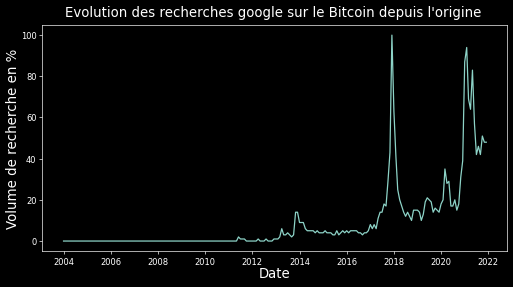

In [12]:
figure(figsize=(10, 5), dpi=60)
plt.plot(data_btc_trend['Mois'],data_btc_trend[['BTC']])
plt.title(label="Evolution des recherches google sur le Bitcoin depuis l'origine ",
         fontsize=16,
         fontfamily="sans-serif",
         pad=10)
plt.xlabel(xlabel="Date",
          fontsize=16,
          fontfamily="sans-serif",
          labelpad=1)
plt.ylabel(ylabel="Volume de recherche en %",
          fontsize=16,
          fontfamily="sans-serif",
          labelpad=1)

# Répartition géographique des mineurs de Bitcoin depuis 2019

In [13]:
data_hash= pd.read_csv('export.csv')

In [14]:
data_hash['date'] = pd.to_datetime(data_hash['date'])
data_hash['monthly_hashrate_%'] = data_hash['monthly_hashrate_%'].str.replace('%','')
data_hash['monthly_hashrate_%'] = data_hash['monthly_hashrate_%'].astype(float)

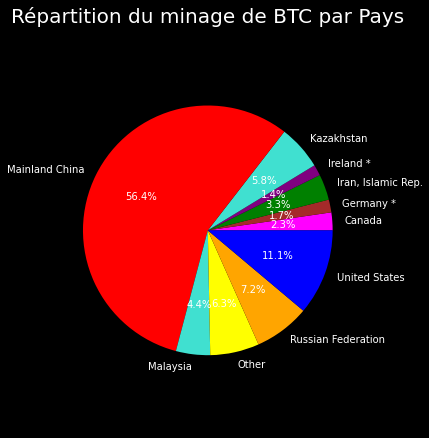

In [15]:
fig1,ax1=plt.subplots(figsize=(6,6))
ax1.pie(data_hash.groupby("country").mean()["monthly_hashrate_%"],
        labels=np.sort(data_hash["country"].unique()),
        autopct="%1.1f%%",
       colors=['magenta', 'brown','green','purple','turquoise','red','turquoise','yellow','orange','blue'])
ax1.axis("equal")
plt.tight_layout()
plt.title('Répartition du minage de BTC par Pays', size=20)


plt.show()

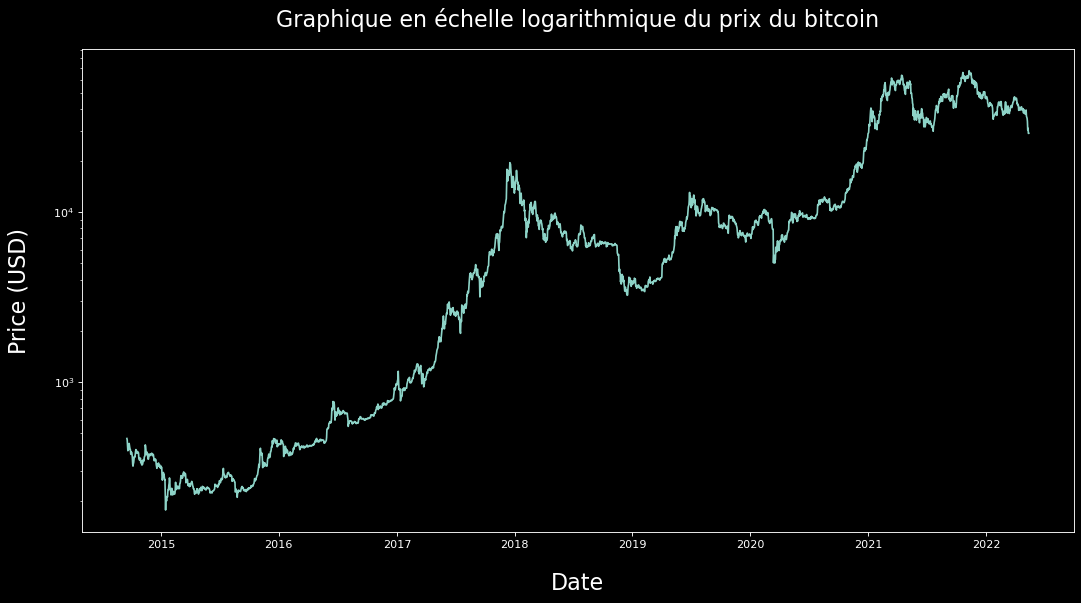

In [16]:
figure(figsize=(16, 8), dpi=80)
plt.semilogy(btcdata["Date"],btcdata["Open"])

plt.title(label="Graphique en échelle logarithmique du prix du bitcoin",
         fontsize=20,
         fontfamily="sans-serif",
         pad=20)

plt.xlabel(xlabel="Date",
          fontsize=20,
          fontfamily="sans-serif",
          labelpad=20)

plt.ylabel(ylabel="Price (USD)",
          fontsize=20,
          fontfamily="sans-serif",
          labelpad=20)

plt.show()

In [17]:
btcdata.set_index('Date',inplace=True)

Text(0, 0.5, 'Price (USD)')

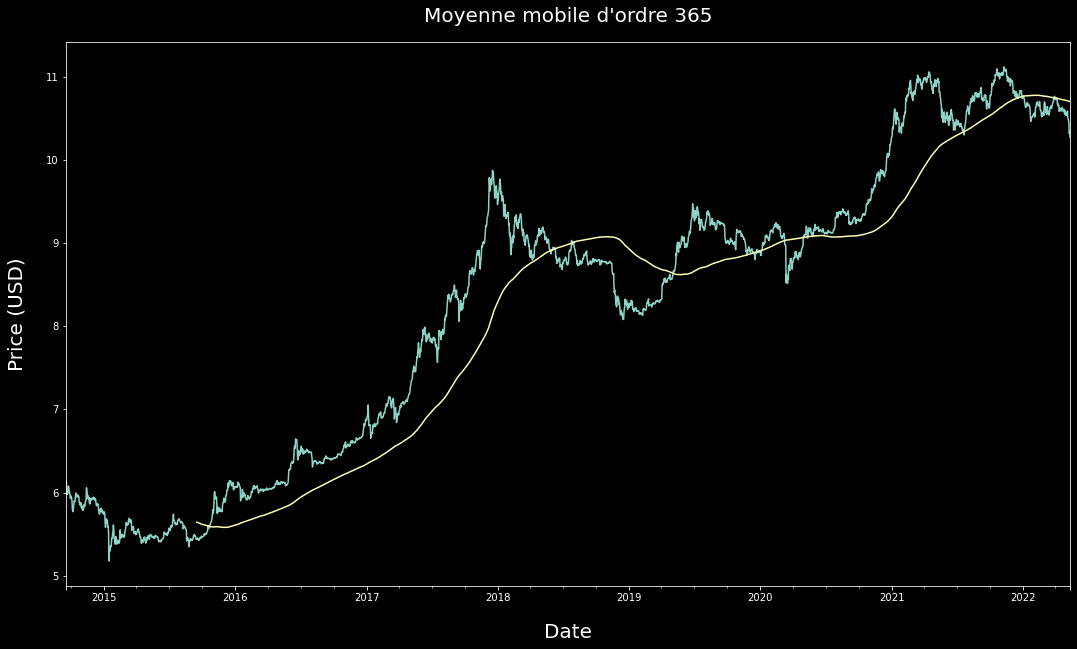

In [18]:
np.log(btcdata['Open']).plot(figsize=(18,10))
np.log(btcdata.rolling(window=365).mean()['Open']).plot()
plt.title(label="Moyenne mobile d'ordre 365",
         fontsize=20,
         fontfamily="sans-serif",
         pad=20)

plt.xlabel(xlabel="Date",
          fontsize=20,
          fontfamily="sans-serif",
          labelpad=20)

plt.ylabel(ylabel="Price (USD)",
          fontsize=20,
          fontfamily="sans-serif",
          labelpad=20)

# Construction des Bandes de Bollinger

In [19]:
btcdata['20 Day Mean'] = btcdata['Open'].rolling(window=20).mean()
btcdata['Upper'] = btcdata['20 Day Mean'] + 2*btcdata['Open'].rolling(20).std()
btcdata['Lower'] = btcdata['20 Day Mean'] - 2*btcdata['Open'].rolling(20).std()

Text(0.5, 1.0, 'Bandes de Bollinger depuis janvier 2021')

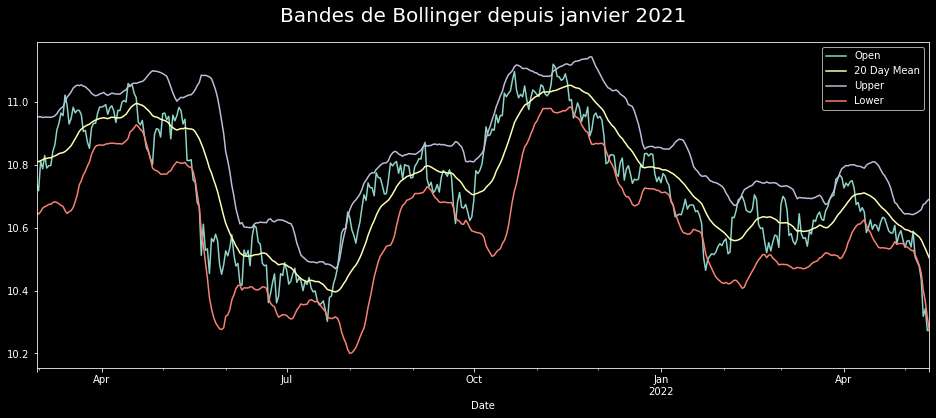

In [20]:
np.log(btcdata[['Open', '20 Day Mean', 'Upper', 'Lower']]).tail(440).plot(figsize=(16,6))
plt.title(label="Bandes de Bollinger depuis janvier 2021",
         fontsize=20,
         fontfamily="sans-serif",
         pad=20)

# Calcul du ROI

In [21]:
latest_price = btcdata['Open'].iloc[-1]
latest_price2 = golddata['Open'].iloc[-1]


In [22]:
btcdata.reset_index(inplace=True)
golddata.reset_index(inplace=True)

In [23]:
btcdata["profit"] = btcdata["Open"]
btcdata["profit"].where(btcdata["profit"] < latest_price, None, inplace = True)
golddata["profit"] = golddata["Open"]
golddata["profit"].where(golddata["profit"] < latest_price2, None, inplace = True)

In [24]:
fig = go.Figure()

fig.add_trace(go.Scatter(
x=btcdata['Date'],
y=btcdata['Open'],
name="Loss",
line = dict(color = "red")
))

fig.add_trace(go.Scatter(
x=btcdata['Date'],
y=btcdata['profit'],
name="Profit",
line = dict(color = "green")
))

total_days = len(btcdata)
total_profitable_days = len(btcdata[btcdata['Open'] <latest_price])
percentage_profitable = round(total_profitable_days/total_days*100,2)

fig.add_annotation(text=f"Total Days: {total_days}",
                  
                  xref='paper', yref="paper",
                  x=0.05, y=1.2, showarrow=False,
                  font=dict(size=20))

fig.add_annotation(text=f"Total Profitable Days: {total_profitable_days}",
                  
                  xref='paper', yref="paper",
                  x=0.05, y=1.1, showarrow=False,
                  font=dict(size=20))

fig.add_annotation(text=f"Percentage profitable Days: {percentage_profitable}",
                  
                  xref='paper', yref="paper",
                  x=0.05, y=1, showarrow=False,
                  font=dict(size=20))

fig.update_layout(template="plotly_dark")
fig.update_yaxes(type ='log',showgrid=False)
fig.update_xaxes(showgrid=False)

fig.show()

In [25]:
fig = go.Figure()

fig.add_trace(go.Scatter(
x=golddata['Date'],
y=golddata['Open'],
name="Loss",
line = dict(color = "red")
))

fig.add_trace(go.Scatter(
x=golddata['Date'],
y=golddata['profit'],
name="Profit",
line = dict(color = "green")
))

total_days = len(golddata)
total_profitable_days = len(golddata[golddata['Open'] <latest_price2])
percentage_profitable = round(total_profitable_days/total_days*100,2)

fig.add_annotation(text=f"Total Days: {total_days}",
                  
                  xref='paper', yref="paper",
                  x=0.05, y=1.2, showarrow=False,
                  font=dict(size=20))

fig.add_annotation(text=f"Total Profitable Days: {total_profitable_days}",
                  
                  xref='paper', yref="paper",
                  x=0.05, y=1.1, showarrow=False,
                  font=dict(size=20))

fig.add_annotation(text=f"Percentage profitable Days: {percentage_profitable}",
                  
                  xref='paper', yref="paper",
                  x=0.05, y=1, showarrow=False,
                  font=dict(size=20))

fig.update_layout(template="plotly_dark")
fig.update_yaxes(type ='log',showgrid=False)
fig.update_xaxes(showgrid=False)

fig.show()

# Rendement Quotidient en pourcentage

In [26]:
#La fonction pct_change de pandas permet de faire le calcul
btcdata['returns'] = btcdata['Open'].pct_change(1)
golddata['returns'] = golddata['Open'].pct_change(1)

In [27]:
plt.rcdefaults() 

In [28]:
plt.style.use('ggplot')

In [29]:
btcdata

Date          Open   20 Day Mean         Upper         Lower  \
0    2014-09-17    465.864014           NaN           NaN           NaN   
1    2014-09-18    456.859985           NaN           NaN           NaN   
2    2014-09-19    424.102997           NaN           NaN           NaN   
3    2014-09-20    394.673004           NaN           NaN           NaN   
4    2014-09-21    408.084991           NaN           NaN           NaN   
...         ...           ...           ...           ...           ...   
2791 2022-05-09  34060.015625  38630.471094  42513.815695  34747.126492   
2792 2022-05-10  30273.654297  38069.066504  43238.213837  32899.919171   
2793 2022-05-11  31016.183594  37551.299902  43362.283002  31740.316802   
2794 2022-05-12  28936.734375  36971.843457  43762.596586  30181.090328   
2795 2022-05-13  28971.544922  36433.484570  43967.206774  28899.762367   

            profit   returns  
0       465.864014       NaN  
1       456.859985 -0.019328  
2       424.102997 -0.071700  
3       394.673004 -0.069394  
4       408.084991  0.033983  
...            ...       ...  
2791           NaN -0.040642  
2792           NaN -0.111167  
2793           NaN  0.024527  
2794  28936.734375 -0.067044  
2795           NaN  0.001203  

[2796 rows x 7 columns]

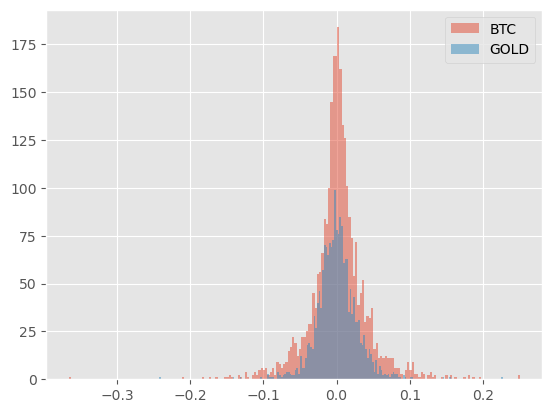

In [30]:
btcdata['returns'].hist(bins=200,label='BTC',alpha=0.5)
golddata['returns'].hist(bins=200,label='GOLD',alpha=0.5)
plt.legend()

Text(0.5, 1.0, 'Distribution des rendements quotidients')

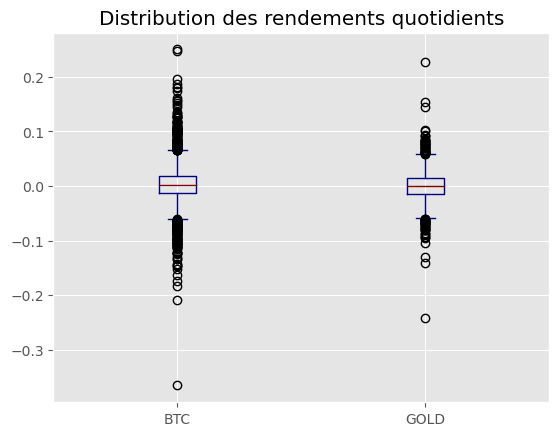

In [31]:
box_df = pd.concat([btcdata['returns'],golddata['returns']],axis=1)
box_df.columns = ['BTC','GOLD']
box_df.plot(kind='box',colormap='jet')
plt.title(label = 'Distribution des rendements quotidients')

# Ratio de Sharpe

In [32]:
for stock_df in (btcdata,golddata):
    stock_df['Normed Return'] = stock_df['Open']/stock_df.iloc[0]['Open']

In [33]:
for stock_df,allo in zip([btcdata,golddata],[.5,.5]):
    stock_df['Allocation'] = stock_df['Normed Return']*allo


In [34]:
btcdata

Date          Open   20 Day Mean         Upper         Lower  \
0    2014-09-17    465.864014           NaN           NaN           NaN   
1    2014-09-18    456.859985           NaN           NaN           NaN   
2    2014-09-19    424.102997           NaN           NaN           NaN   
3    2014-09-20    394.673004           NaN           NaN           NaN   
4    2014-09-21    408.084991           NaN           NaN           NaN   
...         ...           ...           ...           ...           ...   
2791 2022-05-09  34060.015625  38630.471094  42513.815695  34747.126492   
2792 2022-05-10  30273.654297  38069.066504  43238.213837  32899.919171   
2793 2022-05-11  31016.183594  37551.299902  43362.283002  31740.316802   
2794 2022-05-12  28936.734375  36971.843457  43762.596586  30181.090328   
2795 2022-05-13  28971.544922  36433.484570  43967.206774  28899.762367   

            profit   returns  Normed Return  Allocation  
0       465.864014       NaN       1.000000    0.500000  
1       456.859985 -0.019328       0.980672    0.490336  
2       424.102997 -0.071700       0.910358    0.455179  
3       394.673004 -0.069394       0.847185    0.423592  
4       408.084991  0.033983       0.875974    0.437987  
...            ...       ...            ...         ...  
2791           NaN -0.040642      73.111497   36.555749  
2792           NaN -0.111167      64.983887   32.491943  
2793           NaN  0.024527      66.577762   33.288881  
2794  28936.734375 -0.067044      62.114122   31.057061  
2795           NaN  0.001203      62.188845   31.094422  

[2796 rows x 9 columns]

In [35]:
for stock_df in [btcdata,golddata]:
    stock_df['Position Values'] = stock_df['Allocation']*10000

In [36]:
golddata.set_index('Date',inplace=True)

In [37]:
all_pos_vals = [btcdata['Position Values'], golddata['Position Values']]

In [38]:
portfolio_val = pd.concat(all_pos_vals, axis=1)

In [39]:
portfolio_val.columns = ['BTC','GOLD']

In [40]:
portfolio_val = portfolio_val.drop(portfolio_val.index[-48:])

In [41]:
portfolio_val['Total Pos'] = portfolio_val.sum(axis=1)

<AxesSubplot:>

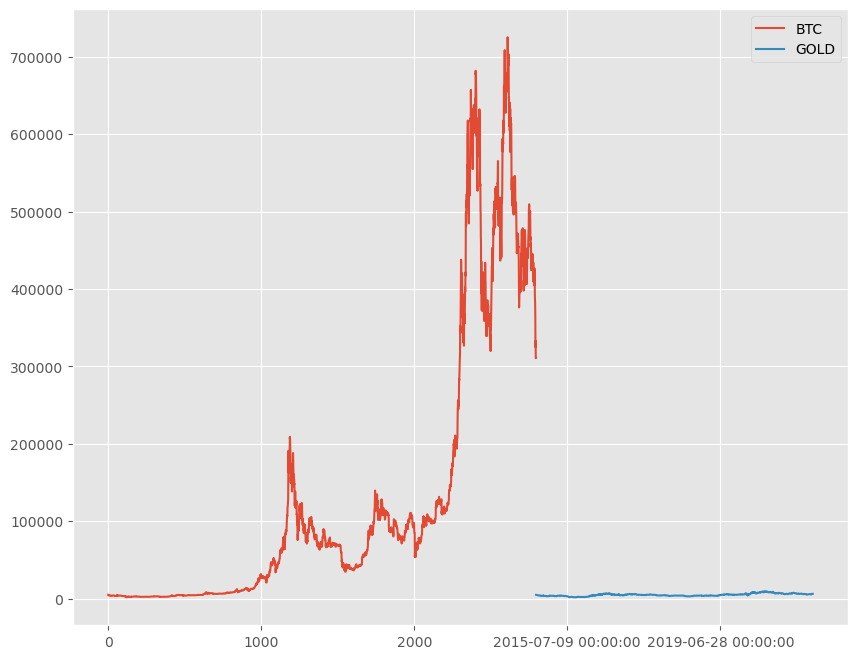

In [42]:
portfolio_val.drop('Total Pos',axis=1).plot(figsize=(10,8))

In [43]:
portfolio_val['Daily Return'] = portfolio_val['Total Pos'].pct_change(1)

In [44]:
btcdata

Date          Open   20 Day Mean         Upper         Lower  \
0    2014-09-17    465.864014           NaN           NaN           NaN   
1    2014-09-18    456.859985           NaN           NaN           NaN   
2    2014-09-19    424.102997           NaN           NaN           NaN   
3    2014-09-20    394.673004           NaN           NaN           NaN   
4    2014-09-21    408.084991           NaN           NaN           NaN   
...         ...           ...           ...           ...           ...   
2791 2022-05-09  34060.015625  38630.471094  42513.815695  34747.126492   
2792 2022-05-10  30273.654297  38069.066504  43238.213837  32899.919171   
2793 2022-05-11  31016.183594  37551.299902  43362.283002  31740.316802   
2794 2022-05-12  28936.734375  36971.843457  43762.596586  30181.090328   
2795 2022-05-13  28971.544922  36433.484570  43967.206774  28899.762367   

            profit   returns  Normed Return  Allocation  Position Values  
0       465.864014       NaN       1.000000    0.500000      5000.000000  
1       456.859985 -0.019328       0.980672    0.490336      4903.362054  
2       424.102997 -0.071700       0.910358    0.455179      4551.789625  
3       394.673004 -0.069394       0.847185    0.423592      4235.924997  
4       408.084991  0.033983       0.875974    0.437987      4379.872446  
...            ...       ...            ...         ...              ...  
2791           NaN -0.040642      73.111497   36.555749    365557.487007  
2792           NaN -0.111167      64.983887   32.491943    324919.433659  
2793           NaN  0.024527      66.577762   33.288881    332888.811794  
2794  28936.734375 -0.067044      62.114122   31.057061    310570.612086  
2795           NaN  0.001203      62.188845   31.094422    310944.224834  

[2796 rows x 10 columns]

In [45]:
#On part du principe que le Taux sans risque est à 0%

In [46]:
Sharpe_BTC = btcdata['returns'].mean()/btcdata['returns'].std()

Sharpe_GOLD = golddata['returns'].mean()/golddata['returns'].std()

In [47]:
# Le Ratio de Sharpe est une méthode créer pour des données annuelles,
# il faut donc annualisé le Ratio => 252 jours ouvré pour l'or et 365 pour le Bitcoin

In [48]:
ASR_GOLD = (np.sqrt(252))*Sharpe_GOLD

In [49]:
ASR_BTC = (np.sqrt(365))*Sharpe_BTC

In [50]:
print(ASR_GOLD)
print(ASR_BTC)

0.25785207221129314
1.103055496755506


# Modélisation du prix avec la méthode Holt-Winters 

In [51]:
btcdata.set_index('Date',inplace=True)

In [52]:
y = np.log(btcdata['Open'])

/Users/alexandremasson05/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/alexandremasson05/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



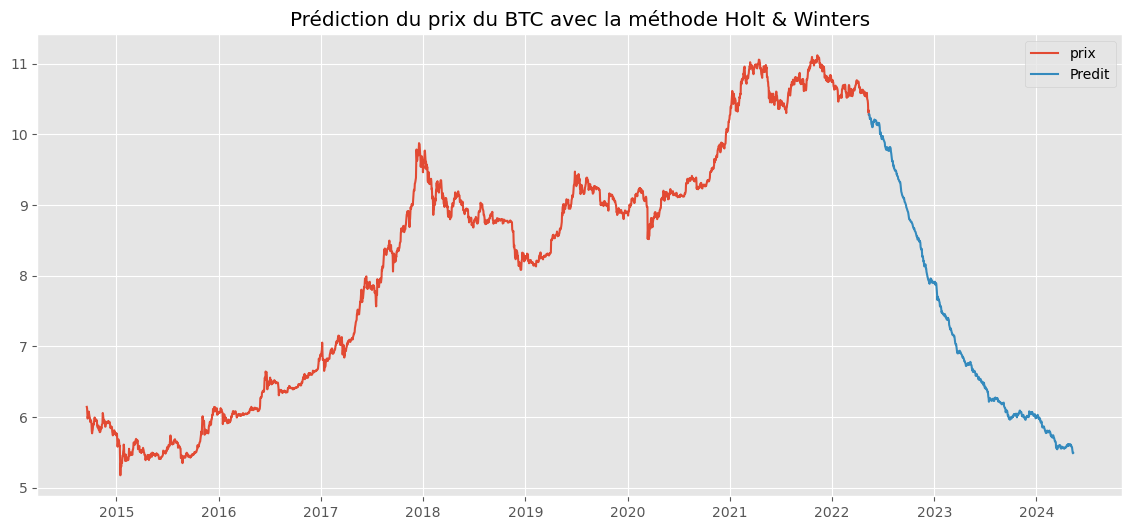

In [53]:
hw = ExponentialSmoothing(np.asarray(y), seasonal_periods=730, trend='mul', seasonal='mul').fit()
hw_pred = hw.forecast(730)

plt.figure(figsize=(14,6))
plt.plot(y, label='prix')
plt.plot(pd.date_range(y.index[len(y)-1], periods=730, freq='D'), hw_pred, label='Predit')
plt.title('Prédiction du prix du BTC avec la méthode Holt & Winters')
plt.legend()
plt.show()

In [54]:
btcdata_test = btcdata.drop(btcdata.index[-730:])
y_test = np.log(btcdata_test['Open'])

/Users/alexandremasson05/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/alexandremasson05/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



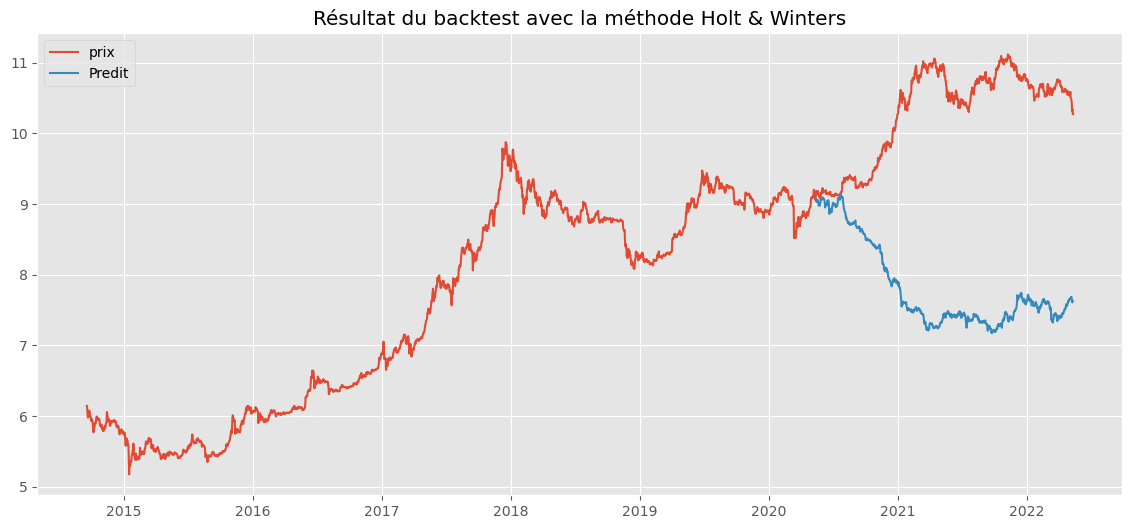

In [55]:
hw = ExponentialSmoothing(np.asarray(y_test), seasonal_periods=730, trend='mul', seasonal='mul').fit()
hw_pred = hw.forecast(730)

plt.figure(figsize=(14,6))
plt.plot(y, label='prix')
plt.plot(pd.date_range(y_test.index[len(y_test)-1], periods=730, freq='D'), hw_pred, label='Predit')
plt.title('Résultat du backtest avec la méthode Holt & Winters')
plt.legend()
plt.show()

# Stratégie du Buy and Hold 

In [56]:
#Utilisation de l'API de Binance pour avoir les données en horaire
KlinesT = Client().get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "01 May 2013")
df = pd.DataFrame(KlinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume',
                                      'close_time', 'quote_av', 'trades', 'tb_base_av',
                                      'tb_quote_av', 'ignore'])

ReadTimeout: HTTPSConnectionPool(host='api.binance.com', port=443): Read timed out. (read timeout=10)

In [ ]:
df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
df = df.set_index(df['timestamp'])
df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
df.index = pd.to_datetime(df.index, unit='ms') 

In [ ]:
df

In [ ]:
VD = 10000
VA = (VD/ df['close'].iloc[0]) * df['close'].iloc[-1]
VA

In [ ]:
print('Le buy and hold à génerer un résultat de',((VA - VD) / VD)*100 ,'%')

# Stratégie du croisement de deux moyennes mobiles

In [ ]:
#Création des 2 moyennes mobiles (200 heures et 600 heures)
df['SMA200'] = ta.trend.sma_indicator(df['close'], 200)
df['SMA600'] = ta.trend.sma_indicator(df['close'], 600)

In [ ]:
#Je test ma stratégie avec un portefueille de 10000$
usdt = 10000
btc = 0
lastIndex = df.first_valid_index()

In [ ]:
#Je créer l'algorithme qui va me permettre d'acheter ou de vendre à chaque croisement des deux moyennes
for index, row in df.iterrows():
    if df['SMA200'][lastIndex] > df['SMA600'][lastIndex] and usdt > 1:
        btc = usdt / df['close'][index] 
        btc = btc - 0.0007 * btc
        usdt = 0
        print("Buy BTC at",df['close'][index],'$ the', index)

    if df['SMA200'][lastIndex] < df['SMA600'][lastIndex] and btc > 0.0001:
        usdt = btc * df['close'][index]
        usdt = usdt - 0.0007 * usdt
        btc = 0
        print("Sell BTC at",df['close'][index],'$ the', index)
    lastIndex = index

In [ ]:
finalResult = usdt + btc * df['close'].iloc[-1]
print("Résultat final", finalResult, 'USDT')

In [ ]:
VD2 = 10000
VA2 = finalResult

In [ ]:
print('Le croisement des deux moyennes mobiles à génerer un résultat de',((VA2 - VD2) / VD2)*100 ,'%')

In [ ]:
plt.style.use("dark_background")

In [ ]:
df[['SMA200','SMA600','close']].tail(6000).plot(figsize=(16,6))
plt.title(label="Visualisation des deux moyennes mobiles",
         fontsize=20,
         fontfamily="sans-serif",
         pad=20)

plt.xlabel(xlabel="Date",
          fontsize=20,
          fontfamily="sans-serif",
          labelpad=20)

plt.ylabel(ylabel="Price (USD)",
          fontsize=20,
          fontfamily="sans-serif",
          labelpad=20)

plt.show()

# Backtest

In [ ]:
dfTest = df.copy()

In [ ]:
dt = None
dt = pd.DataFrame(columns = ['date','position', 'price', 'frais' ,'fiat', 'coins', 'wallet', 'drawBack'])

usdt = 10000
initalWallet = usdt
coin = 0
wallet = 10000
lastAth = 0
lastIndex = df.first_valid_index()
fee = 0.0007

In [ ]:
for index, row in dfTest.iterrows():
    if row['SMA200'] > row['SMA600'] and usdt > 1:
        coin = usdt / row['close']
        frais = fee * coin
        coin = coin - frais
        usdt = 0
        wallet = coin * row['close']
        if wallet > lastAth:
            lastAth = wallet
        print("Buy COIN at",df['close'][index],'$ the', index)
        myrow = {'date': index,'position': "Buy",'price': row['close'],'frais': frais * row['close'],'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
        dt = dt.append(myrow,ignore_index=True)

    if row['SMA200'] < row['SMA600'] and coin > 0.0001:
        usdt = coin * row['close']
        frais = fee * usdt
        usdt = usdt - frais
        coin = 0
        wallet = usdt
        if wallet > lastAth:
            lastAth = wallet
        print("Sell COIN at",df['close'][index],'$ the', index)
        myrow = {'date': index,'position': "Sell",'price': row['close'],'frais': frais,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
        dt = dt.append(myrow,ignore_index=True)
        
        lastIndex = index

In [ ]:
print("Period : [" + str(dfTest.index[0]) + "] -> [" +str(dfTest.index[len(dfTest)-1]) + "]")
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

dt['tradeIs'] = ''
dt.loc[dt['resultat']>0,'tradeIs'] = 'Good'
dt.loc[dt['resultat']<=0,'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPorcentage = ((lastClose - iniClose)/iniClose) * 100
algoPorcentage = ((wallet - initalWallet)/initalWallet) * 100
vsHoldPorcentage = ((algoPorcentage - holdPorcentage)/holdPorcentage) * 100

print("Starting balance : 10000 $")
print("Final balance :",round(wallet,2),"$")
print("Performance vs US Dollar :",round(algoPorcentage,2),"%")
print("Buy and Hold Performence :",round(holdPorcentage,2),"%")
print("Performance vs Buy and Hold :",round(vsHoldPorcentage,2),"%")
print("Number of negative trades : ",dt.groupby('tradeIs')['date'].nunique()['Bad'])
print("Number of positive trades : ",dt.groupby('tradeIs')['date'].nunique()['Good'])
print("Average Positive Trades : ",round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(),2),"%")
print("Average Negative Trades : ",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(),2),"%")
idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
print("Best trade +"+str(round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(),2)),"%, the ",dt['date'][idbest])
print("Worst trade",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(),2),"%, the ",dt['date'][idworst])
print("Worst drawBack", str(100*round(dt['drawBack'].min(),2)),"%")
print("Total fee : ",round(dt['frais'].sum(),2),"$")

dt[['wallet','price']].plot(subplots=True, figsize=(12,10))
print('PLOT')

In [ ]:
dt

In [ ]:
# ==> pour le dashboard
#dt.to_csv('backtest.csv')